## Import library

In [1]:
import pandas as pd
import numpy as np
import os

## Defining the Path


In [2]:
TABULAR_DATA_PATH = 'C:/Users/2XIN/Desktop/Data Science/Diamond/Dataset/finalData.csv' # Corrected path
IMAGE_DIR_PATH = "Dataset/image" # Still from previous example

## Loading Tabular Data

In [3]:
df = pd.DataFrame() # Initialize df as empty DataFrame
tabular_ids = set() # Initialize tabular_ids as empty set

# Try common encodings
encodings_to_try = ['utf-8', 'latin1', 'cp1252', 'ISO-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv(TABULAR_DATA_PATH, encoding=encoding)
        # If successfully read, break the loop
        print(f"Successfully loaded tabular data using encoding: {encoding}")
        break
    except UnicodeDecodeError:
        print(f"Failed to load with encoding: {encoding}. Trying next...")
    except FileNotFoundError:
        print(f"Error: Tabular data file not found at {TABULAR_DATA_PATH}. Please check the path.")
        break # No point trying other encodings if file not found
    except Exception as e:
        print(f"An unexpected error occurred while loading tabular data with {encoding}: {e}")
        break # Other unexpected errors might need manual debug

if not df.empty: # Check if DataFrame was successfully loaded
    df['id_str'] = df['Id'].astype(str)
    tabular_ids = set(df['id_str'].tolist())
    print(f"Number of rows in tabular data: {len(df)}")
    print(f"Number of unique IDs in tabular data: {len(tabular_ids)}")
    print("Tabular DataFrame Head:")
    print(df.head())
else:
    print("Could not load tabular data with any of the tried encodings.")


Failed to load with encoding: utf-8. Trying next...
Successfully loaded tabular data using encoding: latin1
Number of rows in tabular data: 5952
Number of unique IDs in tabular data: 5952
Tabular DataFrame Head:
        Id    Shape  Weight Clarity Colour Cut Polish Symmetry Fluorescence  \
0  1771083  CUSHION    0.43     SI1      M  EX     EX       VG            M   
1  1524552  CUSHION    0.52     VS1    S-T  EX     EX       VG            M   
2  1651023  CUSHION    0.50     SI1      M  EX     EX       VG            F   
3  1632749  CUSHION    0.50     VS2      M  VG     EX       GD            N   
4  1660174  CUSHION    0.50    VVS2      M  EX     EX       VG            F   

     Messurements   Price                                           Data Url  \
0  4.38-4.34×2.72  683.22  https://capitalwholesalediamonds.com/product/0...   
1  4.55-4.38×2.97  718.92  https://capitalwholesalediamonds.com/product/0...   
2  4.86-4.23×2.87  725.32  https://capitalwholesalediamonds.com/product/0

## Loading Images

In [4]:
from PIL import Image

image_ids = set()
# This dictionary will store image ID -> full_path for linking
valid_image_paths_dict = {}

if os.path.exists(IMAGE_DIR_PATH):
    print(f"Scanning single image directory: {IMAGE_DIR_PATH}/")
    for filename in os.listdir(IMAGE_DIR_PATH):
        # Check for common image extensions (case-insensitive)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Extract ID from filename (e.g., '12345.jpg' -> '12345')
            diamond_id = os.path.splitext(filename)[0]
            full_image_path = os.path.join(IMAGE_DIR_PATH, filename)

            # Optional: A quick check to ensure the image can be opened by PIL
            # This catches any remaining silently corrupted files that might have slipped through
            try:
                with Image.open(full_image_path) as img:
                    img.verify() # Verify file integrity
                # Store the ID and its full path only if valid
                image_ids.add(diamond_id)
                valid_image_paths_dict[diamond_id] = full_image_path
            except (IOError, SyntaxError) as e:
                print(f"Warning: Skipping corrupted or unreadable image file: {filename} ({e})")
            except Exception as e:
                print(f"Unexpected error with image {filename}: {e}. Skipping.")
else:
    print(f"Error: Image directory not found at {IMAGE_DIR_PATH}. Please check the path.")

print(f"Number of unique IDs found in cleaned image files: {len(image_ids)}")
print(f"Number of valid image paths collected: {len(valid_image_paths_dict)}")




Scanning single image directory: Dataset/image/
Number of unique IDs found in cleaned image files: 5793
Number of valid image paths collected: 5793


## Finding the actual pairs
Finding images that have matchin id with rows

In [5]:
print("\n--- Linking Tabular and Image Data ---")
# IDs present in both tabular data AND image files
common_ids = tabular_ids.intersection(image_ids)
print(f"Number of common IDs (present in both tabular and image data): {len(common_ids)}")

# IDs present in tabular data but NOT in image files (missing photos for these)
tabular_only_ids = tabular_ids.difference(image_ids)
print(f"Number of IDs in tabular data but NOT in image files (missing photos): {len(tabular_only_ids)}")

# IDs present in image files but NOT in tabular data (extra photos without corresponding tabular data)
image_only_ids = image_ids.difference(tabular_ids)
print(f"Number of IDs in image files but NOT in tabular data (extra photos): {len(image_only_ids)}")


--- Linking Tabular and Image Data ---
Number of common IDs (present in both tabular and image data): 4359
Number of IDs in tabular data but NOT in image files (missing photos): 1593
Number of IDs in image files but NOT in tabular data (extra photos): 1434


## Linking images with data

In [43]:
# 1. DataFrame for the Hybrid Model (only rows with both tabular data AND a matching image)
df_hybrid = df[df['id_str'].isin(common_ids)].copy()
df_hybrid['image_path'] = df_hybrid['id_str'].map(valid_image_paths_dict)

print("\n--- df_hybrid DataFrame Info (for multi-modal model) ---")
print(f"Rows in df_hybrid: {len(df_hybrid)}")
# Double-check that all image paths are present
print(f"Any missing image paths in df_hybrid? {df_hybrid['image_path'].isnull().any()}")
print("df_hybrid Head (with image_path):")
print(df_hybrid[['Id', 'id_str', 'image_path']].head())


# 2. DataFrame for the Tabular-Only Model (all original tabular data, with a flag)
df_tabular_only_strategy = df.copy()
df_tabular_only_strategy['has_image'] = df_tabular_only_strategy['id_str'].isin(common_ids)

print("\n--- df_tabular_only_strategy DataFrame Info (for tabular-only model) ---")
print(f"Rows in df_tabular_only_strategy: {len(df_tabular_only_strategy)}")
print(f"Number of rows with images in df_tabular_only_strategy: {df_tabular_only_strategy['has_image'].sum()}")
print("df_tabular_only_strategy Head (with has_image flag):")
print(df_tabular_only_strategy[['Id', 'id_str', 'has_image']].head())

df_hybrid.to_csv('diamond_with_image_path.csv', index=False)


--- df_hybrid DataFrame Info (for multi-modal model) ---
Rows in df_hybrid: 4359
Any missing image paths in df_hybrid? False
df_hybrid Head (with image_path):
        Id   id_str                 image_path
1  1524552  1524552  Dataset/image\1524552.jpg
2  1651023  1651023  Dataset/image\1651023.jpg
3  1632749  1632749  Dataset/image\1632749.jpg
4  1660174  1660174  Dataset/image\1660174.jpg
7  1602072  1602072  Dataset/image\1602072.jpg

--- df_tabular_only_strategy DataFrame Info (for tabular-only model) ---
Rows in df_tabular_only_strategy: 5952
Number of rows with images in df_tabular_only_strategy: 4359
df_tabular_only_strategy Head (with has_image flag):
        Id   id_str  has_image
0  1771083  1771083      False
1  1524552  1524552       True
2  1651023  1651023       True
3  1632749  1632749       True
4  1660174  1660174       True


## EDA

In [7]:
df_hybrid.drop('Data Url', axis=1, inplace=True)


In [8]:
df_hybrid.head()

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,Price,id_str,image_path
1,1524552,CUSHION,0.52,VS1,S-T,EX,EX,VG,M,4.55-4.38×2.97,718.92,1524552,Dataset/image\1524552.jpg
2,1651023,CUSHION,0.50,SI1,M,EX,EX,VG,F,4.86-4.23×2.87,725.32,1651023,Dataset/image\1651023.jpg
3,1632749,CUSHION,0.50,VS2,M,VG,EX,GD,N,4.51-4.47×2.98,771.13,1632749,Dataset/image\1632749.jpg
4,1660174,CUSHION,0.50,VVS2,M,EX,EX,VG,F,4.94-4.27×2.88,772.88,1660174,Dataset/image\1660174.jpg
7,1602072,CUSHION,0.59,VS2,U-V,VG,EX,GD,N,4.64-4.57×3.19,807.91,1602072,Dataset/image\1602072.jpg


In [9]:
df_tabular_only_strategy.drop('Data Url', axis=1, inplace=True)

In [10]:
df_tabular_only_strategy.head()

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,Price,id_str,has_image
0,1771083,CUSHION,0.43,SI1,M,EX,EX,VG,M,4.38-4.34×2.72,683.22,1771083,False
1,1524552,CUSHION,0.52,VS1,S-T,EX,EX,VG,M,4.55-4.38×2.97,718.92,1524552,True
2,1651023,CUSHION,0.50,SI1,M,EX,EX,VG,F,4.86-4.23×2.87,725.32,1651023,True
3,1632749,CUSHION,0.50,VS2,M,VG,EX,GD,N,4.51-4.47×2.98,771.13,1632749,True
4,1660174,CUSHION,0.50,VVS2,M,EX,EX,VG,F,4.94-4.27×2.88,772.88,1660174,True


## Image preprocessing

In [11]:
TARGET_IMAGE_SIZE = (224, 224)

# --- Define the Image Preprocessing Function ---
def preprocess_image(image_path, target_size=TARGET_IMAGE_SIZE):
    """
    Loads an image, converts it to RGB, resizes it, and normalizes pixel values.
    """
    try:
        # Open the image using Pillow. Convert to 'RGB' to handle PNGs (RGBA) consistently
        # and ensure 3 channels.
        img = Image.open(image_path).convert('RGB')

        # Resize the image. Image.Resampling.LANCZOS is a high-quality downsampling filter.
        img = img.resize(target_size, Image.Resampling.LANCZOS)

        # Convert the image to a NumPy array
        img_array = np.array(img)

        # Normalize pixel values to 0-1 range
        # For CNNs, it's common to normalize to 0-1 (by dividing by 255.0)
        # or to -1 to 1 depending on the pre-trained model's requirements.
        # Starting with 0-1 is generally safe.
        img_array = img_array / 255.0

        return img_array
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}. Returning None.")
        return None
    except Exception as e:
        print(f"Error processing image {image_path}: {e}. Returning None.")
        return None


In [12]:
# --- Apply Preprocessing to df_hybrid ---
print("\n--- Starting Image Preprocessing for df_hybrid ---")
# Apply the preprocessing function to each image path in df_hybrid
# This will create a new column 'preprocessed_image_array' which holds the NumPy array for each image.
df_hybrid['preprocessed_image_array'] = df_hybrid['image_path'].apply(preprocess_image)

# Check for any images that failed preprocessing (returned None)
failed_images_count = df_hybrid['preprocessed_image_array'].isnull().sum()
if failed_images_count > 0:
    print(f"Warning: {failed_images_count} images failed preprocessing and were set to None. Consider investigating these.")
    # You might want to remove these rows from df_hybrid if they are critical
    df_hybrid = df_hybrid.dropna(subset=['preprocessed_image_array'])
    print(f"Removed failed image rows. df_hybrid now has {len(df_hybrid)} rows.")

# Verify the shape of a preprocessed image
if not df_hybrid.empty:
    sample_image_array = df_hybrid['preprocessed_image_array'].iloc[0]
    print(f"\nShape of a sample preprocessed image: {sample_image_array.shape}")
    print(f"Min pixel value: {sample_image_array.min()}, Max pixel value: {sample_image_array.max()}")
else:
    print("No images successfully preprocessed.")

print("\nImage Preprocessing Complete.")


--- Starting Image Preprocessing for df_hybrid ---

Shape of a sample preprocessed image: (224, 224, 3)
Min pixel value: 0.0, Max pixel value: 1.0

Image Preprocessing Complete.


In [13]:
print("\n1. DataFrame Info:")
df_tabular_only_strategy.info()

print("\n2. Descriptive Statistics:")
print(df_tabular_only_strategy.describe())


1. DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            5952 non-null   object 
 1   Shape         5952 non-null   object 
 2   Weight        5952 non-null   float64
 3   Clarity       5952 non-null   object 
 4   Colour        5952 non-null   object 
 5   Cut           5952 non-null   object 
 6   Polish        5952 non-null   object 
 7   Symmetry      5945 non-null   object 
 8   Fluorescence  5952 non-null   object 
 9   Messurements  5952 non-null   object 
 10  Price         5952 non-null   float64
 11  id_str        5952 non-null   object 
 12  has_image     5952 non-null   bool   
dtypes: bool(1), float64(2), object(10)
memory usage: 563.9+ KB

2. Descriptive Statistics:
            Weight         Price
count  5952.000000   5952.000000
mean      0.469069   1639.946551
std       0.257283   1509.201707
min 

## Parsing of measurement column

In [14]:
import re

print("--- Parsing 'Messurements' Column ---")

def parse_measurements(measurement_str):
    """
    Parses a string like 'x.xx x y.yy x z.zz' into a tuple of floats (x, y, z).
    Returns (np.nan, np.nan, np.nan) if parsing fails.
    """
    if pd.isna(measurement_str) or not isinstance(measurement_str, str):
        return np.nan, np.nan, np.nan
    try:
        # Use regex to find numbers that look like floats, separated by ' x '
        # This regex looks for a sequence of digits, optionally followed by a dot and more digits
        parts = re.findall(r'(\d+\.?\d*)', measurement_str)
        if len(parts) == 3:
            return float(parts[0]), float(parts[1]), float(parts[2])
        elif len(parts) > 0 and len(parts) < 3: # Handle cases with fewer than 3 dimensions if they exist
            # For simplicity, if only one or two dimensions, fill with NaN for missing ones
            return tuple([float(p) for p in parts] + [np.nan] * (3 - len(parts)))
        else:
            return np.nan, np.nan, np.nan # No numbers found or unexpected format
    except (ValueError, TypeError):
        return np.nan, np.nan, np.nan # Catch errors during conversion

# Apply the parsing function
# df_tabular_only_strategy[['x', 'y', 'z']] = df_tabular_only_strategy['Messurements'].apply(
#     lambda s: pd.Series(parse_measurements(s))
# )
# Correction based on previous memory: All columns start with a capital letter.
# So, we should create 'X', 'Y', 'Z'
df_tabular_only_strategy[['X', 'Y', 'Z']] = df_tabular_only_strategy['Messurements'].apply(
    lambda s: pd.Series(parse_measurements(s))
)


print("\nUpdated DataFrame Info after parsing 'Messurements':")
df_tabular_only_strategy.info()

--- Parsing 'Messurements' Column ---

Updated DataFrame Info after parsing 'Messurements':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            5952 non-null   object 
 1   Shape         5952 non-null   object 
 2   Weight        5952 non-null   float64
 3   Clarity       5952 non-null   object 
 4   Colour        5952 non-null   object 
 5   Cut           5952 non-null   object 
 6   Polish        5952 non-null   object 
 7   Symmetry      5945 non-null   object 
 8   Fluorescence  5952 non-null   object 
 9   Messurements  5952 non-null   object 
 10  Price         5952 non-null   float64
 11  id_str        5952 non-null   object 
 12  has_image     5952 non-null   bool   
 13  X             5952 non-null   float64
 14  Y             5952 non-null   float64
 15  Z             5952 non-null   float64
dtypes: bool(1), float64(5)

In [15]:
print("\n3. Missing Values Check:")
missing_values = df_tabular_only_strategy.isnull().sum()
print(missing_values[missing_values > 0]) # Only show columns with missing values
if missing_values.sum() == 0:
    print("No missing values found in the tabular data.")

# Separate features into numerical and categorical for easier plotting
numerical_cols = df_tabular_only_strategy.select_dtypes(include=np.number).columns.tolist()
# Exclude 'id' and 'price' from numerical for general feature analysis if they are there
if 'id' in numerical_cols: numerical_cols.remove('id')
if 'price' in numerical_cols: numerical_cols.remove('price') # 'price' is our target

categorical_cols = df_tabular_only_strategy.select_dtypes(include='object').columns.tolist()
# 'has_image' is boolean/numerical, but conceptually categorical, useful to add
if 'has_image' not in categorical_cols and 'has_image' in df_tabular_only_strategy.columns:
    categorical_cols.append('has_image')

print(f"\n4. Numerical Columns: {numerical_cols}")
print(f"   Categorical Columns: {categorical_cols}")



3. Missing Values Check:
Symmetry    7
dtype: int64

4. Numerical Columns: ['Weight', 'Price', 'X', 'Y', 'Z']
   Categorical Columns: ['Id', 'Shape', 'Clarity', 'Colour', 'Cut', 'Polish', 'Symmetry', 'Fluorescence', 'Messurements', 'id_str', 'has_image']


## Plotting charts


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# --- Specify columns to EXCLUDE from plotting ---
# Add any column names here that you do NOT want to plot.
columns_to_exclude = ['id_str', 'Id', 'Messurements', 'has_image'] # Example: 'id_str' is just an identifier, 'has_image' might be too simple for detailed charts here

# Create the list of categorical columns to plot
categorical_cols_to_plot = [col for col in categorical_cols if col not in columns_to_exclude]

print(f"Categorical columns selected for plotting: {categorical_cols_to_plot}")
print("\n--- Generating Categorical Feature Plots ---")

# Calculate subplot grid dimensions dynamically
num_cols_to_plot = len(categorical_cols_to_plot)
n_cols = 3 # Number of columns per row in the plot grid
n_rows = math.ceil(num_cols_to_plot / n_cols)




Categorical columns selected for plotting: ['Shape', 'Clarity', 'Colour', 'Cut', 'Polish', 'Symmetry', 'Fluorescence']

--- Generating Categorical Feature Plots ---


C:\Users\2XIN\AppData\Local\Temp\ipykernel_9128\1344943219.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_tabular_only_strategy, x=col, palette='viridis', order=df_tabular_only_strategy[col].value_counts().index)
C:\Users\2XIN\AppData\Local\Temp\ipykernel_9128\1344943219.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_tabular_only_strategy, x=col, palette='viridis', order=df_tabular_only_strategy[col].value_counts().index)
C:\Users\2XIN\AppData\Local\Temp\ipykernel_9128\1344943219.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same eff

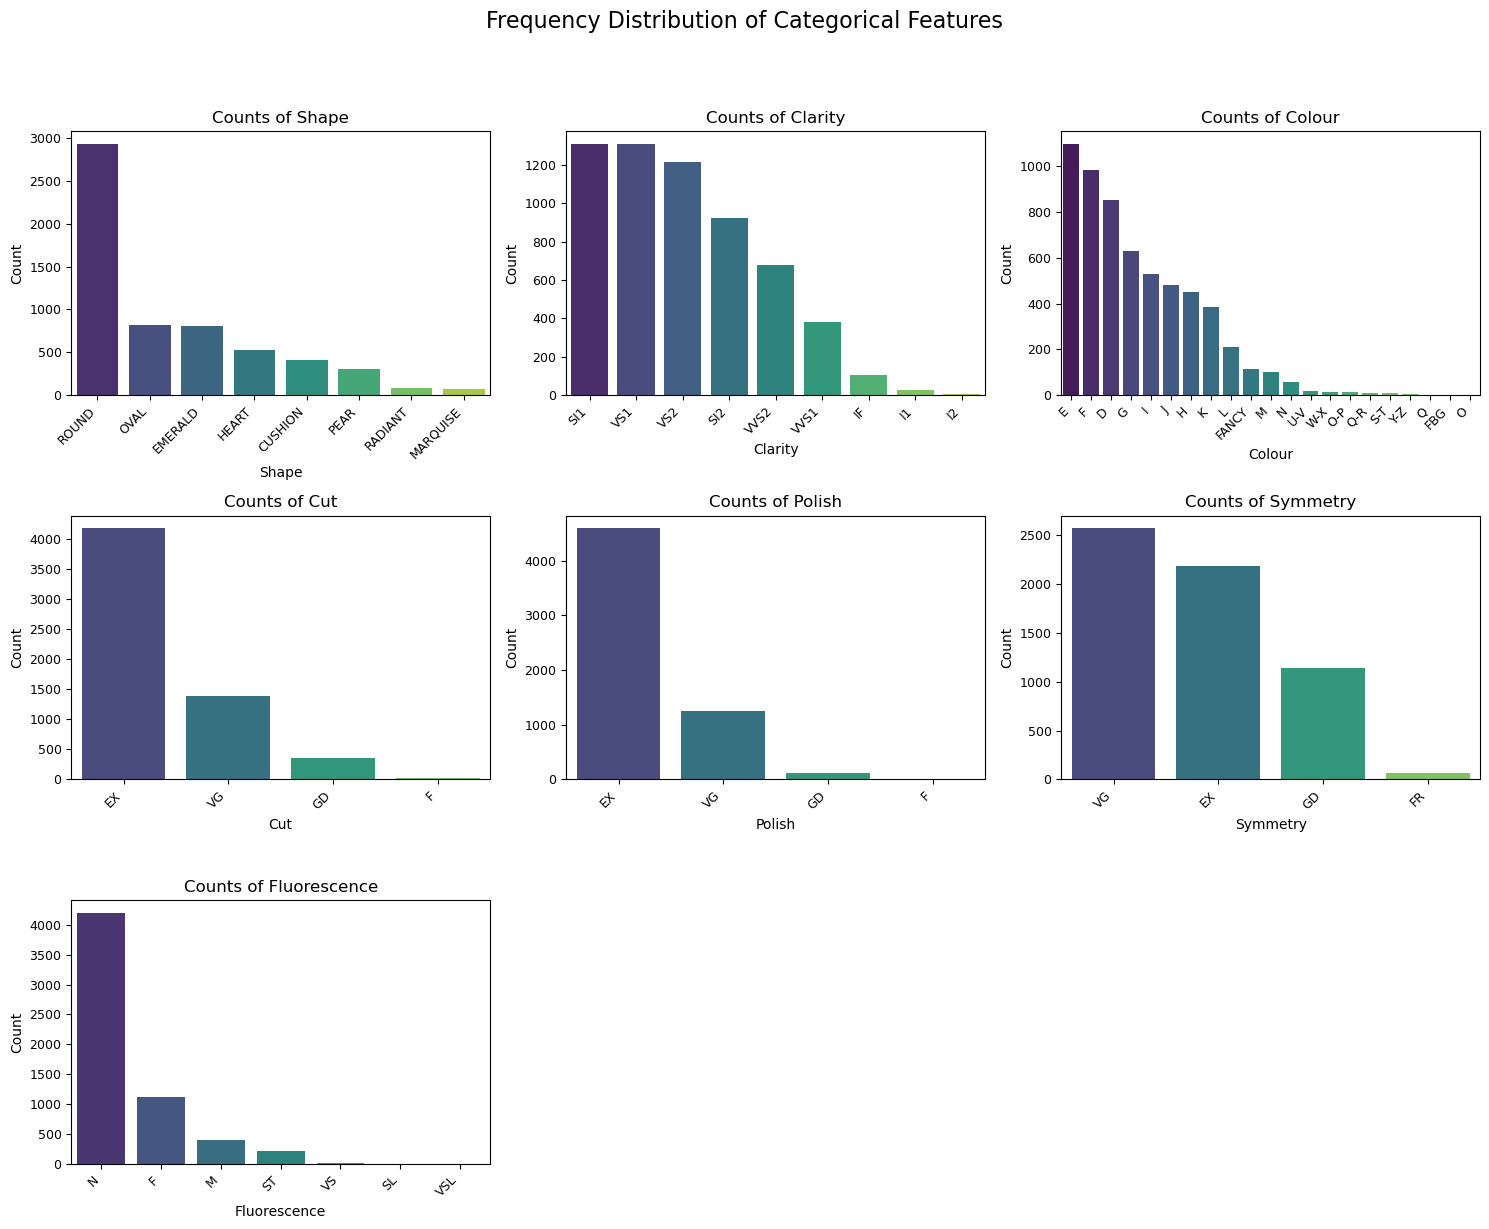

In [17]:
# --- Plot 1: Frequency (Count) Bar Charts ---
if num_cols_to_plot > 0:
    plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figure size dynamically
    plt.suptitle('Frequency Distribution of Categorical Features', y=1.02, fontsize=16) # Overall title

    for i, col in enumerate(categorical_cols_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(data=df_tabular_only_strategy, x=col, palette='viridis', order=df_tabular_only_strategy[col].value_counts().index)
        plt.title(f'Counts of {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Count', fontsize=10)
        plt.xticks(rotation=45, ha='right', fontsize=9) # Rotate labels if they overlap
        plt.yticks(fontsize=9)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
    plt.show()
else:
    print("No categorical columns selected for frequency plots.")


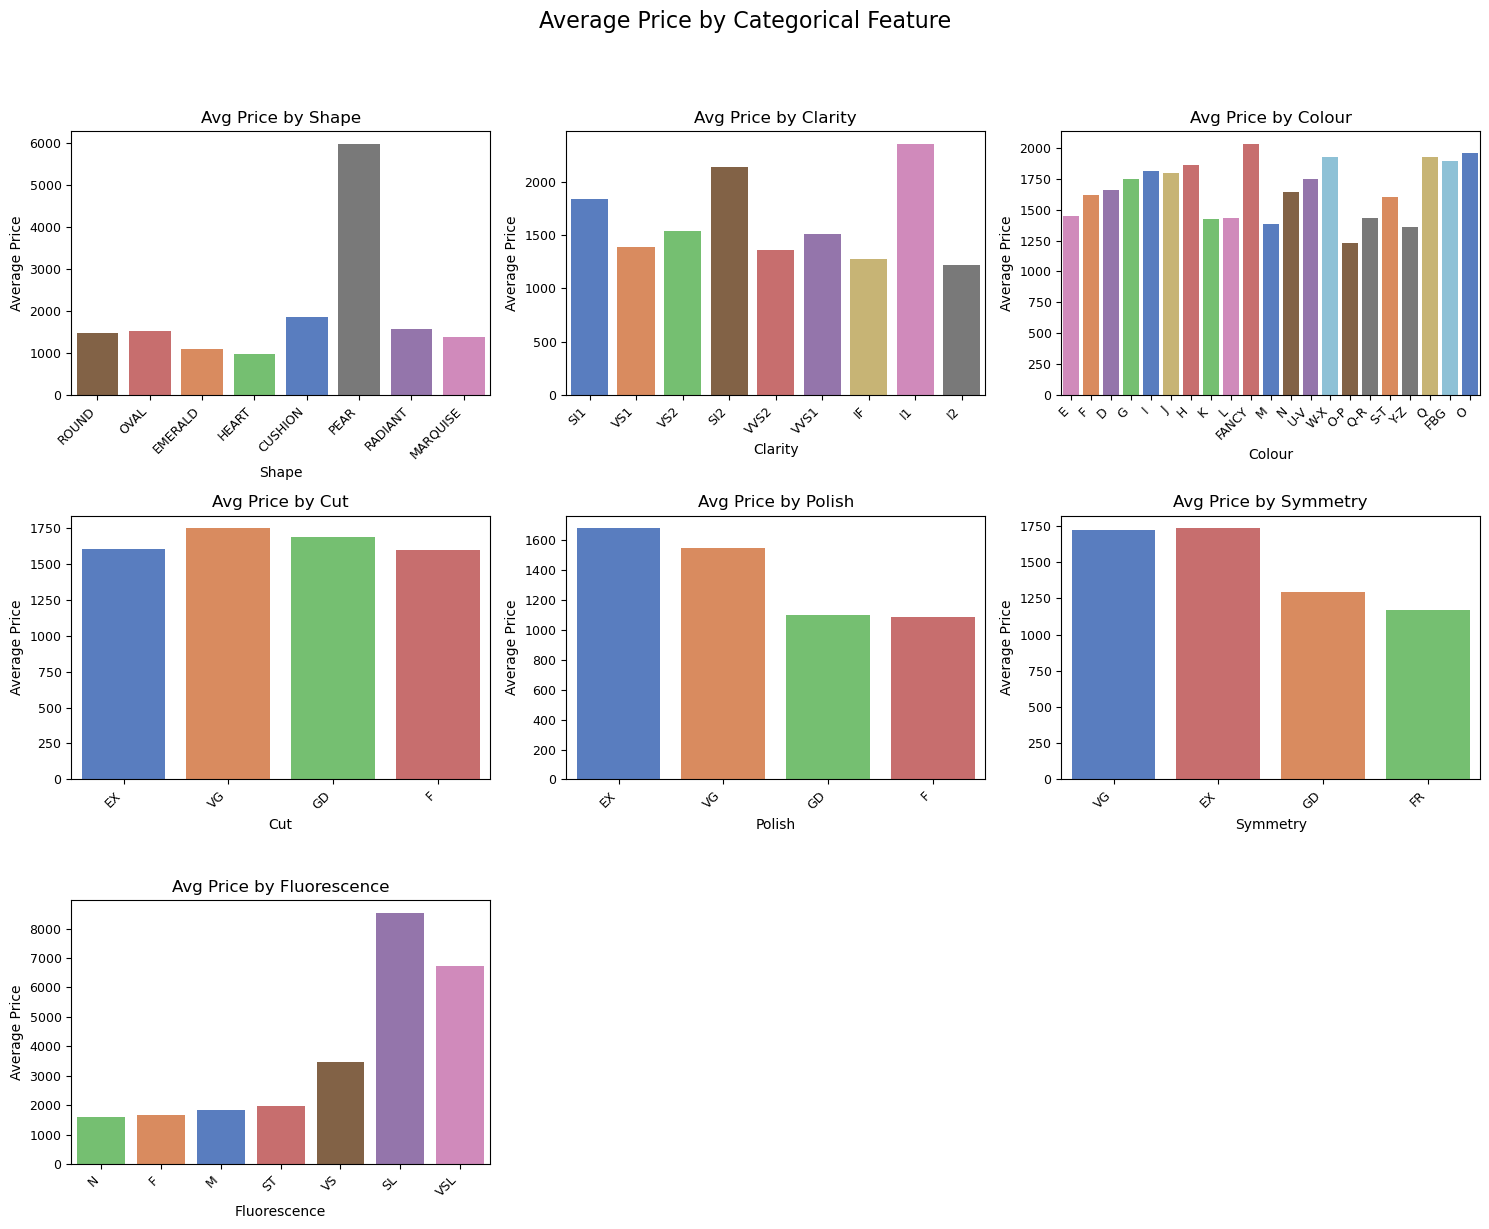

In [18]:
if num_cols_to_plot > 0:
    plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figure size dynamically
    plt.suptitle('Average Price by Categorical Feature', y=1.02, fontsize=16) # Overall title

    for i, col in enumerate(categorical_cols_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        # --- CORRECTED LINE HERE ---
        # Explicitly set y='price' to calculate the average price for each category
        # hue=col and legend=False also moved here to avoid the FutureWarning
        sns.barplot(data=df_tabular_only_strategy, x=col, y='Price', hue=col, palette='muted', errorbar=None, legend=False, order=df_tabular_only_strategy[col].value_counts().index)
        plt.title(f'Avg Price by {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Average Price', fontsize=10)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(fontsize=9)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout
    plt.show()
else:
    print("No categorical columns selected for average price plots.")


--- Starting Numerical Feature Analysis ---


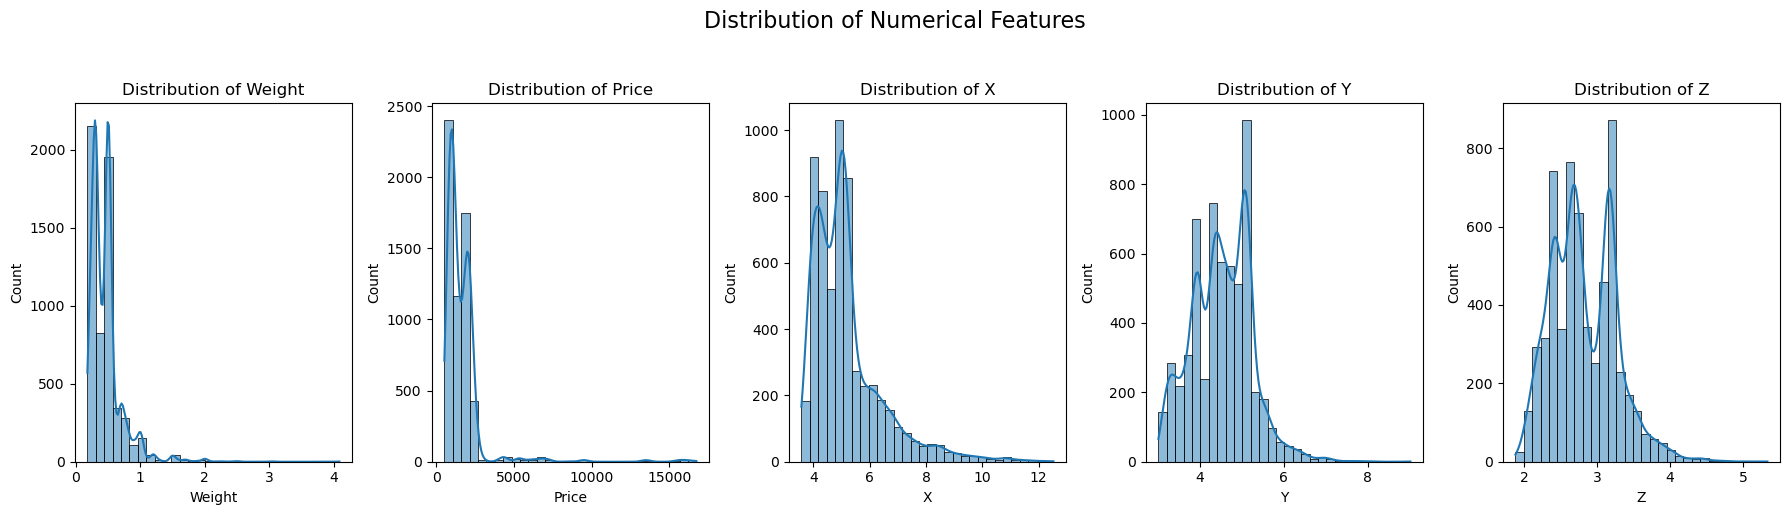

In [19]:
print("\n--- Starting Numerical Feature Analysis ---")

# 1. Distribution plots (Histograms)
plt.figure(figsize=(18, 5)) # Adjust figure size as needed
plt.suptitle('Distribution of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1) # Create subplot for each numerical column
    sns.histplot(df_tabular_only_strategy[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


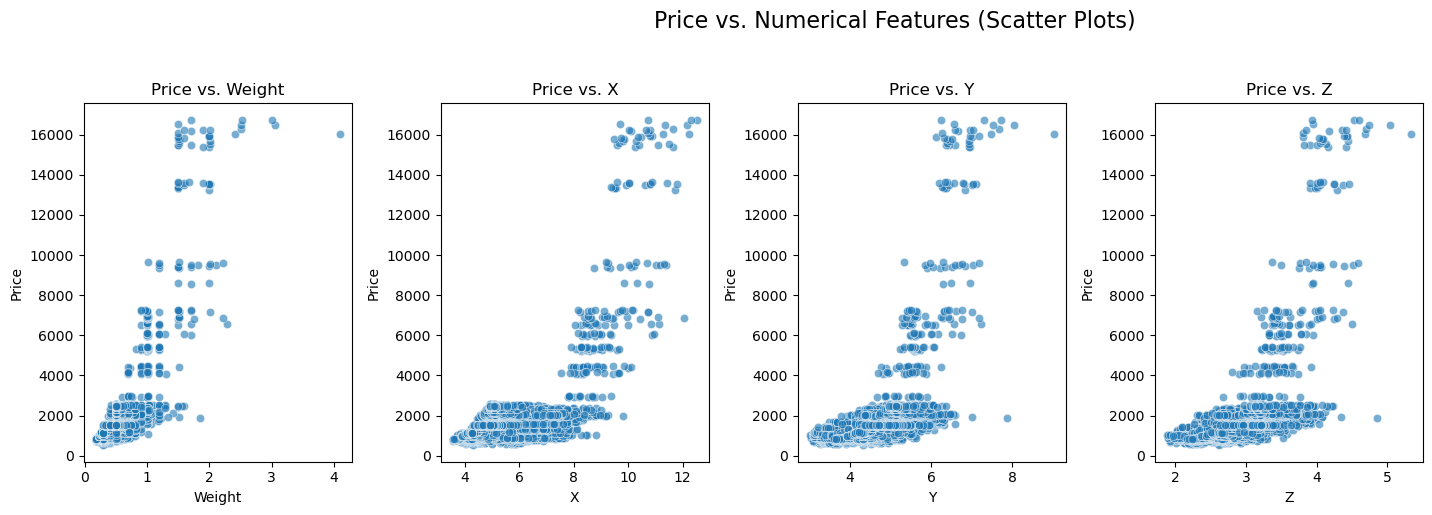

In [20]:
# 2. Relationship of Numerical Features with Price (Scatter Plots)
plt.figure(figsize=(18, 5)) # Adjust figure size as needed
plt.suptitle('Price vs. Numerical Features (Scatter Plots)', y=1.02, fontsize=16)
numerical_cols_without_price = ['Weight', 'X', 'Y', 'Z']
for i, col in enumerate(numerical_cols_without_price):
    plt.subplot(1, len(numerical_cols), i + 1) # Create subplot for each numerical column
    sns.scatterplot(data=df_tabular_only_strategy, x=col, y='Price', alpha=0.6) # Use 'Price' (capital P)
    plt.title(f'Price vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Price')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


--- Correlation Matrix and Heatmap ---


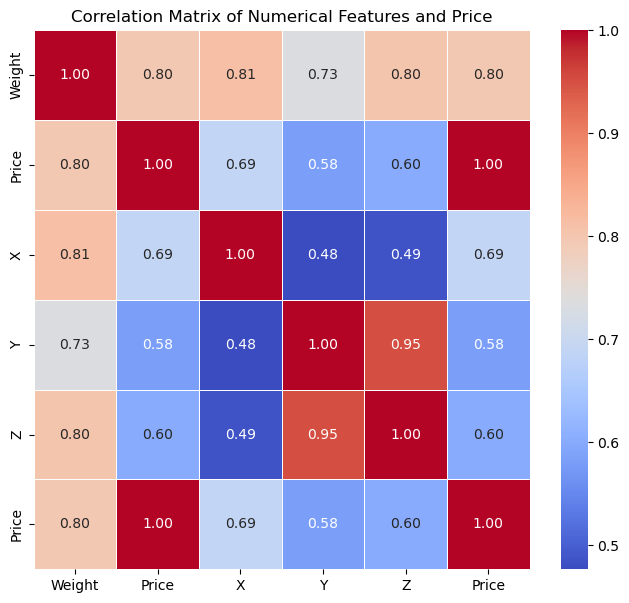


--- Numerical Feature Analysis Complete ---


In [21]:
# 3. Correlation Matrix and Heatmap
print("\n--- Correlation Matrix and Heatmap ---")
# Combine all numerical columns including 'Price' for correlation
correlation_features = numerical_cols + ['Price']
correlation_matrix = df_tabular_only_strategy[correlation_features].corr()

plt.figure(figsize=(8, 7)) # Smaller figure size for fewer numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Price')
plt.show()

print("\n--- Numerical Feature Analysis Complete ---")

## Ordinal encoding of 
cut, polish, clarity and symmetry

In [22]:
df_tabular_only_strategy['Polish'].unique()

array(['EX', 'VG', 'GD', 'F'], dtype=object)

In [23]:
df_tabular_only_strategy['Cut'].unique()

array(['EX', 'VG', 'GD', 'F'], dtype=object)

In [24]:
df_tabular_only_strategy['Symmetry'].unique()

array(['VG', 'GD', 'FR', 'EX', nan], dtype=object)

In [25]:
df_tabular_only_strategy = df_tabular_only_strategy.dropna(subset=['Id']).copy()

In [26]:
print("--- Filling Remaining NaNs with Mode ---")

# Define the categorical columns that still have NaNs (excluding 'Id' which was handled)
#categorical_cols_to_impute_mode = ['Clarity', 'Cut', 'Polish', 'Symmetry', 'Fluorescence']

# Dictionary to store the calculated modes for later use
imputation_modes = {}

for col in categorical_cols:
    # Check if the column actually has NaNs before attempting to fill
    if df_tabular_only_strategy[col].isnull().sum() > 0:
        # Calculate the mode. .mode()[0] is used because mode() can return multiple modes
        # We take the first one if there are ties.
        mode_value = df_tabular_only_strategy[col].mode()[0]
        imputation_modes[col] = mode_value # Store the mode value

        print(f"Filling NaN values in '{col}' with mode: '{mode_value}'")
        df_tabular_only_strategy[col].fillna(mode_value, inplace=True)
    else:
        print(f"No NaN values found in '{col}'. Skipping imputation.")



--- Filling Remaining NaNs with Mode ---
No NaN values found in 'Id'. Skipping imputation.
No NaN values found in 'Shape'. Skipping imputation.
No NaN values found in 'Clarity'. Skipping imputation.
No NaN values found in 'Colour'. Skipping imputation.
No NaN values found in 'Cut'. Skipping imputation.
No NaN values found in 'Polish'. Skipping imputation.
Filling NaN values in 'Symmetry' with mode: 'VG'
No NaN values found in 'Fluorescence'. Skipping imputation.
No NaN values found in 'Messurements'. Skipping imputation.
No NaN values found in 'id_str'. Skipping imputation.
No NaN values found in 'has_image'. Skipping imputation.


In [34]:
from sklearn.preprocessing import OrdinalEncoder

# Assuming df_tabular_only_strategy is available and updated

print("--- Corrected Ordinal Encoding for Cut, Polish, Symmetry, Clarity ---")

# Define the explicit order for each feature individually
quality_order_common = ['F', 'GD', 'VG', 'EX'] # For Cut, Polish, Symmetry
clarity_order = ['I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'] # For Clarity

# Create a dictionary to map column names to their specific order
column_orders = {
    'Cut': quality_order_common,
    'Polish': quality_order_common,
    'Symmetry': quality_order_common,
    'Clarity': clarity_order
}

# Initialize a dictionary to store fitted encoders (in memory)
# Reusing the existing fitted_ordinal_encoders if it exists, otherwise initialize
if 'fitted_ordinal_encoders' not in locals():
    fitted_ordinal_encoders = {}


for col, order_list in column_orders.items(): # Iterate through the dictionary of column and its specific order
    print(f"\n--- Encoding '{col}' ---")
    print(f"Original '{col}' value counts:\n{df_tabular_only_strategy[col].value_counts(dropna=False)}")

    # Initialize OrdinalEncoder with the SPECIFIC ORDER for the current column
    encoder = OrdinalEncoder(categories=[order_list], handle_unknown='use_encoded_value', unknown_value=-1)

    # Fit and transform the column
    df_tabular_only_strategy[col] = encoder.fit_transform(df_tabular_only_strategy[[col]])

    # Store the fitted encoder in memory
    fitted_ordinal_encoders[col] = encoder
    print(f"Encoded '{col}' value counts:\n{df_tabular_only_strategy[col].value_counts(dropna=False)}")
    print(f"Mapping for '{col}': {order_list} -> {[i for i in range(len(order_list))]}")


print("\n--- Ordinal Encoding Complete for Cut, Polish, Symmetry, Clarity ---")

# Display a sample of the DataFrame to see the encoded values
print("\nDataFrame sample with newly encoded ordinal features:")
print(df_tabular_only_strategy[['Cut', 'Polish', 'Symmetry', 'Clarity']].head())

--- Corrected Ordinal Encoding for Cut, Polish, Symmetry, Clarity ---

--- Encoding 'Cut' ---
Original 'Cut' value counts:
Cut
3.0    4173
2.0    1392
1.0     362
0.0      25
Name: count, dtype: int64


ValueError: could not convert string to float: 'F'

In [28]:
df_tabular_only_strategy.head()

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,Price,id_str,has_image,X,Y,Z
0,1771083,CUSHION,0.43,3.0,M,3.0,3.0,2.0,M,4.38-4.34×2.72,683.22,1771083,False,4.38,4.34,2.72
1,1524552,CUSHION,0.52,5.0,S-T,3.0,3.0,2.0,M,4.55-4.38×2.97,718.92,1524552,True,4.55,4.38,2.97
2,1651023,CUSHION,0.50,3.0,M,3.0,3.0,2.0,F,4.86-4.23×2.87,725.32,1651023,True,4.86,4.23,2.87
3,1632749,CUSHION,0.50,4.0,M,2.0,3.0,1.0,N,4.51-4.47×2.98,771.13,1632749,True,4.51,4.47,2.98
4,1660174,CUSHION,0.50,6.0,M,3.0,3.0,2.0,F,4.94-4.27×2.88,772.88,1660174,True,4.94,4.27,2.88


In [29]:
df_tabular_only_strategy.drop(['Messurements' ,'id_str'], axis = 1)

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Price,has_image,X,Y,Z
0,1771083,CUSHION,0.43,3.0,M,3.0,3.0,2.0,M,683.22,False,4.38,4.34,2.72
1,1524552,CUSHION,0.52,5.0,S-T,3.0,3.0,2.0,M,718.92,True,4.55,4.38,2.97
2,1651023,CUSHION,0.50,3.0,M,3.0,3.0,2.0,F,725.32,True,4.86,4.23,2.87
3,1632749,CUSHION,0.50,4.0,M,2.0,3.0,1.0,N,771.13,True,4.51,4.47,2.98
4,1660174,CUSHION,0.50,6.0,M,3.0,3.0,2.0,F,772.88,True,4.94,4.27,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,1789435,ROUND,0.50,4.0,D,2.0,3.0,2.0,N,2453.20,False,4.93,4.96,3.19
5948,1774887,ROUND,0.52,3.0,H,3.0,3.0,3.0,N,2453.41,True,5.11,5.13,3.20
5949,1630512,ROUND,0.50,5.0,H,3.0,3.0,2.0,N,2453.69,True,5.09,5.13,3.12
5950,Eco Diamond 414098415,EMERALD,0.71,2.0,D,2.0,2.0,2.0,N,1188.14,False,5.75,4.16,2.90


In [30]:
df_tabular_only_strategy['Fluorescence'].value_counts()

Fluorescence
N      4201
F      1123
M       396
ST      212
VS       13
SL        4
VSL       3
Name: count, dtype: int64

In [31]:
df_tabular_only_strategy['Clarity'].value_counts()

Clarity
3.0    1310
5.0    1309
4.0    1213
2.0     923
6.0     680
7.0     383
8.0     103
1.0      28
0.0       3
Name: count, dtype: int64

## One hot encoding for Fluorescence

In [32]:
from sklearn.preprocessing import OneHotEncoder
print("--- One-Hot Encoding for Fluorescence ---")

# 1. Define the categories to be clubbed
categories_to_club = ['VS', 'SL', 'VSL']
new_clubbed_category_name = 'Other_Strong_Fluorescence'

# 2. Apply the clubbing
# Create a copy of the column to avoid SettingWithCopyWarning
df_tabular_only_strategy['Fluorescence_Encoded'] = df_tabular_only_strategy['Fluorescence'].copy()
df_tabular_only_strategy['Fluorescence_Encoded'] = df_tabular_only_strategy['Fluorescence_Encoded'].replace(
    categories_to_club, new_clubbed_category_name
)

print(f"\nValue counts for 'Fluorescence' after clubbing rare categories:")
print(df_tabular_only_strategy['Fluorescence_Encoded'].value_counts(dropna=False))


# 3. Perform One-Hot Encoding on the new 'Fluorescence_Encoded' column
# We need to explicitly define the categories to ensure consistent columns after OHE
# The order here is for the OHE, not necessarily ordinal, but common/logical
ohe_fluorescence_categories = ['N', 'F', 'M', 'ST', new_clubbed_category_name]

encoder = OneHotEncoder(categories=[ohe_fluorescence_categories], sparse_output=False, handle_unknown='ignore') # handle_unknown='ignore' will output all zeros for unseen categories

# Fit and transform the column
fluorescence_ohe_array = encoder.fit_transform(df_tabular_only_strategy[['Fluorescence_Encoded']])

# Create a DataFrame from the OHE array with appropriate column names
# encoder.get_feature_names_out() will give names like 'Fluorescence_Encoded_N', 'Fluorescence_Encoded_F' etc.
fluorescence_ohe_df = pd.DataFrame(fluorescence_ohe_array,
                                    columns=encoder.get_feature_names_out(['Fluorescence_Encoded']),
                                    index=df_tabular_only_strategy.index)

# Join the new OHE columns back to the main DataFrame
df_tabular_only_strategy = pd.concat([df_tabular_only_strategy, fluorescence_ohe_df], axis=1)

# Drop the original 'Fluorescence' column and the temporary 'Fluorescence_Encoded' column
df_tabular_only_strategy.drop(columns=['Fluorescence', 'Fluorescence_Encoded'], inplace=True)


print("\n--- One-Hot Encoding for Fluorescence Complete ---")
print("\nDataFrame sample with new Fluorescence OHE columns:")
print(df_tabular_only_strategy.filter(like='Fluorescence_Encoded_').head())
print(f"Number of new columns added for Fluorescence: {fluorescence_ohe_df.shape[1]}")

--- One-Hot Encoding for Fluorescence ---

Value counts for 'Fluorescence' after clubbing rare categories:
Fluorescence_Encoded
N                            4201
F                            1123
M                             396
ST                            212
Other_Strong_Fluorescence      20
Name: count, dtype: int64

--- One-Hot Encoding for Fluorescence Complete ---

DataFrame sample with new Fluorescence OHE columns:
   Fluorescence_Encoded_N  Fluorescence_Encoded_F  Fluorescence_Encoded_M  \
0                     0.0                     0.0                     1.0   
1                     0.0                     0.0                     1.0   
2                     0.0                     1.0                     0.0   
3                     1.0                     0.0                     0.0   
4                     0.0                     1.0                     0.0   

   Fluorescence_Encoded_ST  Fluorescence_Encoded_Other_Strong_Fluorescence  
0                      0.0     

In [33]:
df_tabular_only_strategy.head()

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Messurements,Price,id_str,has_image,X,Y,Z,Fluorescence_Encoded_N,Fluorescence_Encoded_F,Fluorescence_Encoded_M,Fluorescence_Encoded_ST,Fluorescence_Encoded_Other_Strong_Fluorescence
0,1771083,CUSHION,0.43,3.0,M,3.0,3.0,2.0,4.38-4.34×2.72,683.22,1771083,False,4.38,4.34,2.72,0.0,0.0,1.0,0.0,0.0
1,1524552,CUSHION,0.52,5.0,S-T,3.0,3.0,2.0,4.55-4.38×2.97,718.92,1524552,True,4.55,4.38,2.97,0.0,0.0,1.0,0.0,0.0
2,1651023,CUSHION,0.50,3.0,M,3.0,3.0,2.0,4.86-4.23×2.87,725.32,1651023,True,4.86,4.23,2.87,0.0,1.0,0.0,0.0,0.0
3,1632749,CUSHION,0.50,4.0,M,2.0,3.0,1.0,4.51-4.47×2.98,771.13,1632749,True,4.51,4.47,2.98,1.0,0.0,0.0,0.0,0.0
4,1660174,CUSHION,0.50,6.0,M,3.0,3.0,2.0,4.94-4.27×2.88,772.88,1660174,True,4.94,4.27,2.88,0.0,1.0,0.0,0.0,0.0


## COLOR ENCODING

In [31]:
df_tabular_only_strategy['Colour'].value_counts()

Colour
E        1098
F         982
D         852
G         631
I         527
J         481
H         452
K         384
L         210
FANCY     112
M          99
N          58
U-V        18
W-X        12
O-P        12
Q-R        10
S-T         7
Y-Z         4
Q           1
FBG         1
O           1
Name: count, dtype: int64

In [36]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Assuming df_tabular_only_strategy is available and updated

print("--- Encoding Colour Column (Hybrid Approach) ---")

# --- Step 1: Create Colour_IsFancy One-Hot Encoded Column ---
fancy_colors = ['FANCY', 'FBG']
df_tabular_only_strategy['Colour_IsFancy'] = df_tabular_only_strategy['Colour'].isin(fancy_colors).astype(int)

print(f"\nCreated 'Colour_IsFancy' column. Value counts:\n{df_tabular_only_strategy['Colour_IsFancy'].value_counts(dropna=False)}")

# --- Step 2: Prepare original 'Colour' column for Ordinal Encoding ---

# Make a temporary copy to modify for ordinal encoding
df_tabular_only_strategy['Colour_Ordinal_Temp'] = df_tabular_only_strategy['Colour'].copy()

# Replace rare single letters with their respective ranges
df_tabular_only_strategy['Colour_Ordinal_Temp'] = df_tabular_only_strategy['Colour_Ordinal_Temp'].replace('Q', 'Q-R')
df_tabular_only_strategy['Colour_Ordinal_Temp'] = df_tabular_only_strategy['Colour_Ordinal_Temp'].replace('O', 'O-P')

# Identify the mode of the NON-FANCY colors to fill in for FANCY/FBG entries
# Filter out fancy colors before calculating mode
non_fancy_colors = df_tabular_only_strategy[~df_tabular_only_strategy['Colour_Ordinal_Temp'].isin(fancy_colors)]['Colour_Ordinal_Temp']
mode_non_fancy = non_fancy_colors.mode()[0]
print(f"\nMode of non-fancy colors: '{mode_non_fancy}' (used to fill 'FANCY'/'FBG' entries for ordinal encoding)")

# Replace 'FANCY' and 'FBG' in the temporary column with the mode
df_tabular_only_strategy['Colour_Ordinal_Temp'] = df_tabular_only_strategy['Colour_Ordinal_Temp'].replace(
    fancy_colors, mode_non_fancy
)


# --- Step 3: Define the Ordinal Order for the D-Z Scale ---
# This order is from worst (Y-Z) to best (D) to map to 0, 1, 2...
colour_ordinal_order = [
    'Y-Z', 'W-X', 'U-V', 'S-T', 'Q-R', 'O-P',
    'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'
]

print(f"\nFinal categories for ordinal encoding in order (worst to best):\n{colour_ordinal_order}")
print(f"Value counts for 'Colour_Ordinal_Temp' BEFORE encoding:\n{df_tabular_only_strategy['Colour_Ordinal_Temp'].value_counts(dropna=False)}")


# --- Step 4: Apply Ordinal Encoding ---
encoder = OrdinalEncoder(categories=[colour_ordinal_order], handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the temporary column, overwriting the original 'Colour' column with encoded values
# (After this, the original 'Colour' column will be numerical based on this temporary column)
df_tabular_only_strategy['Colour'] = encoder.fit_transform(df_tabular_only_strategy[['Colour_Ordinal_Temp']])

# Store the fitted encoder in memory
if 'fitted_ordinal_encoders' not in locals():
    fitted_ordinal_encoders = {}
fitted_ordinal_encoders['Colour'] = encoder

print(f"\nEncoded 'Colour' value counts (now in original column):\n{df_tabular_only_strategy['Colour'].value_counts(dropna=False)}")
print(f"Mapping for 'Colour': {colour_ordinal_order} -> {[i for i in range(len(colour_ordinal_order))]}")

# Drop the temporary column
df_tabular_only_strategy.drop(columns=['Colour_Ordinal_Temp'], inplace=True)


print("\n--- Colour Encoding Complete (Hybrid Approach) ---")
print("\nDataFrame sample with updated 'Colour' (ordinal) and new 'Colour_IsFancy' (binary):")
print(df_tabular_only_strategy[['Colour', 'Colour_IsFancy']].head())

--- Encoding Colour Column (Hybrid Approach) ---

Created 'Colour_IsFancy' column. Value counts:
Colour_IsFancy
0    5839
1     113
Name: count, dtype: int64

Mode of non-fancy colors: 'E' (used to fill 'FANCY'/'FBG' entries for ordinal encoding)

Final categories for ordinal encoding in order (worst to best):
['Y-Z', 'W-X', 'U-V', 'S-T', 'Q-R', 'O-P', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D']
Value counts for 'Colour_Ordinal_Temp' BEFORE encoding:
Colour_Ordinal_Temp
E      1211
F       982
D       852
G       631
I       527
J       481
H       452
K       384
L       210
M        99
N        58
U-V      18
O-P      13
W-X      12
Q-R      11
S-T       7
Y-Z       4
Name: count, dtype: int64

Encoded 'Colour' value counts (now in original column):
Colour
15.0    1211
14.0     982
16.0     852
13.0     631
11.0     527
10.0     481
12.0     452
9.0      384
8.0      210
7.0       99
6.0       58
2.0       18
5.0       13
1.0       12
4.0       11
3.0        7
0.0        4

In [22]:
df_tabular_only_strategy.head(10)

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,Price,id_str,has_image,X,Y,Z
0,1771083,CUSHION,0.43,SI1,M,EX,EX,VG,M,4.38-4.34×2.72,683.22,1771083,False,4.38,4.34,2.72
1,1524552,CUSHION,0.52,VS1,S-T,EX,EX,VG,M,4.55-4.38×2.97,718.92,1524552,True,4.55,4.38,2.97
2,1651023,CUSHION,0.50,SI1,M,EX,EX,VG,F,4.86-4.23×2.87,725.32,1651023,True,4.86,4.23,2.87
3,1632749,CUSHION,0.50,VS2,M,VG,EX,GD,N,4.51-4.47×2.98,771.13,1632749,True,4.51,4.47,2.98
4,1660174,CUSHION,0.50,VVS2,M,EX,EX,VG,F,4.94-4.27×2.88,772.88,1660174,True,4.94,4.27,2.88
5,1784948,CUSHION,0.40,VS2,K,VG,EX,VG,M,4.51-3.85×2.68,795.69,1784948,False,4.51,3.85,2.68
6,1755000,CUSHION,0.34,SI1,FANCY,EX,VG,VG,M,4.03-3.88×2.67,803.43,1755000,False,4.03,3.88,2.67
7,1602072,CUSHION,0.59,VS2,U-V,VG,EX,GD,N,4.64-4.57×3.19,807.91,1602072,True,4.64,4.57,3.19
8,1652706,CUSHION,0.51,SI1,N,EX,EX,VG,F,4.92-4.27×2.89,816.68,1652706,True,4.92,4.27,2.89
9,1606825,CUSHION,0.50,VVS1,L,VG,EX,VG,ST,4.72-4.23×2.95,822.17,1606825,True,4.72,4.23,2.95


## PIPELINE

Rather than doing this complex preprocessing of different columns in weird way, we are going to create a pipeline that will handle missing values, encode all columns both ordinal and one hot encoding and will standardise the numerical variables

In [29]:
df_tabular_only_strategy.drop(['Id', 'Messurements', 'id_str'], axis = 1, inplace = True)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
import joblib # For saving and loading the pipeline

# --- IMPORTANT: Ensure df_tabular_only_strategy is in its initial "clean" state ---
# (i.e., after loading CSV, dropping 'Id', parsing 'Messurements', but BEFORE any other encoding/imputation)

print("--- Starting Full Preprocessing Pipeline Construction ---")

# --- Step 0: Separate Target Variable (Price) ---
# Assuming 'Price' is the target column
y = df_tabular_only_strategy['Price']
X = df_tabular_only_strategy.drop(columns=['Price'])

print("\n--- Separated Target Variable 'Price' ---")
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

--- Starting Full Preprocessing Pipeline Construction ---

--- Separated Target Variable 'Price' ---
Shape of X (features): (5952, 12)
Shape of y (target): (5952,)


In [32]:
# --- Step 1: Pre-pipeline Feature Engineering for 'Colour' ---
# (These steps are specific to Colour's mixed nature and done before the main pipeline)

print("\n--- Pre-pipeline Feature Engineering for 'Colour' ---")

# 1.1 Create Colour_IsFancy binary column
fancy_colors = ['FANCY', 'FBG']
X['Colour_IsFancy'] = X['Colour'].isin(fancy_colors).astype(int)
print(f"Created 'Colour_IsFancy' column. Value counts:\n{X['Colour_IsFancy'].value_counts(dropna=False)}")

# 1.2 Replace rare single letters with their respective ranges in original 'Colour' column
X['Colour'] = X['Colour'].replace('Q', 'Q-R')
X['Colour'] = X['Colour'].replace('O', 'O-P')

# 1.3 Replace 'FANCY' and 'FBG' in the original 'Colour' column with the mode of non-fancy colors
non_fancy_colours_series = X[~X['Colour'].isin(fancy_colors)]['Colour']
if not non_fancy_colours_series.empty:
    mode_non_fancy = non_fancy_colours_series.mode()[0]
    X['Colour'] = X['Colour'].replace(fancy_colors, mode_non_fancy)
    print(f"Replaced 'FANCY'/'FBG' in 'Colour' with mode '{mode_non_fancy}'.")
else:
    print("No non-fancy colors found to calculate mode for 'Colour'. Skipping mode replacement for 'FANCY'/'FBG'.")




--- Pre-pipeline Feature Engineering for 'Colour' ---
Created 'Colour_IsFancy' column. Value counts:
Colour_IsFancy
0    5839
1     113
Name: count, dtype: int64
Replaced 'FANCY'/'FBG' in 'Colour' with mode 'E'.

--- Defined Column Types for Pipeline ---


In [33]:
print("\n--- Defined Column Types for Pipeline ---")
# --- Step 2: Define Column Types for the Pipeline ---

# Numerical features (Price is now excluded)
numerical_features = ['Weight', 'X', 'Y', 'Z']

# Ordinal Categorical features
ordinal_features = ['Cut', 'Polish', 'Symmetry', 'Clarity', 'Colour']

# Nominal Categorical features
# Added 'Shape' here. 'Fluorescence' remains nominal, 'Colour_IsFancy' will be treated as nominal (binary)
nominal_features = ['Fluorescence', 'Shape', 'Colour_IsFancy']


--- Defined Column Types for Pipeline ---


In [34]:
# --- Step 3: Build Preprocessing Transformers ---

print("\n--- Building Preprocessing Transformers ---")

# 3.1 Numerical Transformer: Impute with median, then Scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Median is robust to outliers
    ('scaler', StandardScaler())
])

# 3.2 Ordinal Categorical Transformer: Impute with most frequent, then Ordinal Encode
# We need to provide the correct order for each ordinal feature
quality_order_common = ['F', 'GD', 'VG', 'EX']
clarity_order = ['I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
colour_order = [
    'Y-Z', 'W-X', 'U-V', 'S-T', 'Q-R', 'O-P',
    'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'
]

ordinal_encoder_categories = [
    quality_order_common, # For 'Cut'
    quality_order_common, # For 'Polish'
    quality_order_common, # For 'Symmetry'
    clarity_order,        # For 'Clarity'
    colour_order          # For 'Colour'
]

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Mode for categorical NaNs
    ('ordinal_encoder', OrdinalEncoder(categories=ordinal_encoder_categories,
                                       handle_unknown='use_encoded_value',
                                       unknown_value=-1)) # Assign -1 for unseen categories
])

# 3.3 Nominal Categorical Transformer: Impute with most frequent, then One-Hot Encode
# handle_unknown='ignore' will output all zeros for unseen categories
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


--- Building Preprocessing Transformers ---


In [35]:
# --- Step 4: Combine with ColumnTransformer ---

print("\n--- Creating ColumnTransformer ---")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_transformer, nominal_features)
    ],
    remainder='drop' # Explicitly drop any columns not specified
)


# --- Step 5: Create the Full Preprocessing Pipeline ---
full_preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

print("\n--- Preprocessing Pipeline Created ---")
print(full_preprocessing_pipeline)




--- Creating ColumnTransformer ---

--- Preprocessing Pipeline Created ---
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Weight', 'X', 'Y', 'Z']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder

In [36]:
# --- Step 6: Fit and Transform Data ---
print("\n--- Fitting and Transforming Data with Pipeline ---")

# Fit the pipeline on your features (X) and then transform them
df_transformed_array = full_preprocessing_pipeline.fit_transform(X)



--- Fitting and Transforming Data with Pipeline ---


In [39]:
# --- Step 7: Get Transformed Column Names and Create Final DataFrame ---

print("\n--- Generating Transformed DataFrame ---")

# Get names for numerical features (scaled)
transformed_column_names = numerical_features

# Get names for ordinal features (encoded)
transformed_column_names.extend(ordinal_features)

# Get names for nominal (one-hot encoded) features
# Access the onehot_encoder step within the 'nom' transformer within the 'preprocessor'
onehot_feature_names = full_preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['nom']['onehot_encoder'].get_feature_names_out(nominal_features)
transformed_column_names.extend(onehot_feature_names)


# Create a new DataFrame from the transformed array
df_preprocessed_X = pd.DataFrame(df_transformed_array, columns=transformed_column_names, index=X.index)

print("Shape of original features (X):", X.shape)
print("Shape of transformed features (df_preprocessed_X):", df_preprocessed_X.shape)
print("\nSample of transformed features DataFrame (df_preprocessed_X):")
print(df_preprocessed_X.head())


--- Generating Transformed DataFrame ---


ValueError: Shape of passed values is (5952, 26), indices imply (5952, 70)

In [40]:
# --- Step 8: Save the Pipeline and Processed Data ---

print("\n--- Saving Pipeline and Processed Data ---")

# Save the fitted pipeline
pipeline_filename = 'full_preprocessing_pipeline.joblib'
joblib.dump(full_preprocessing_pipeline, pipeline_filename)
print(f"Preprocessing pipeline saved to: {pipeline_filename}")

# Save the processed features (X) to a new CSV
processed_X_filename = 'processed_diamond_features_X.csv'
df_preprocessed_X.to_csv(processed_X_filename, index=False)
print(f"Processed features (X) saved to: {processed_X_filename}")

# You should also save your target variable (y) separately if you wish, or handle it directly in your model training script
y_filename = 'diamond_target_y.csv'
y.to_csv(y_filename, index=False)
print(f"Target variable (y) saved to: {y_filename}")


print("\nAll preprocessing, pipeline building, and saving complete!")


--- Saving Pipeline and Processed Data ---
Preprocessing pipeline saved to: full_preprocessing_pipeline.joblib
Processed features (X) saved to: processed_diamond_features_X.csv
Target variable (y) saved to: diamond_target_y.csv

All preprocessing, pipeline building, and saving complete!
